In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. IMPORTS ET CHARGEMENT DES DONNÉES (déjà fait)
import pandas as pd
import re

df = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/data/Homo_sapien.xlsx')

# 2. PRÉTRAITEMENT INITIAL (comme vous l'aviez fait)
df = df.drop(['LocusTag', 'Synonyms', 'dbXrefs', 'Feature_type'], axis=1)
df.columns = df.columns.str.replace('#', '')
df.replace('-', pd.NA, inplace=True)
df.drop_duplicates(subset='GeneID', keep='first', inplace=True)

# 3. ANALYSE DES VALEURS MANQUANTES
print("=== ANALYSE VALEURS MANQUANTES ===")
missing_percent = df.isnull().sum() / len(df) * 100
print("Pourcentage de valeurs manquantes par colonne :")
print(missing_percent[missing_percent > 0])

# 4. NETTOYAGE : SUPPRESSION map_location NULL ET COLONNES REDONDANTES
# Supprimer les lignes où map_location est null
df_clean = df.dropna(subset=['map_location']).copy()

# Colonnes avec trop de valeurs manquantes à supprimer
columns_to_drop = [
    'Symbol_from_nomenclature_authority',
    'Full_name_from_nomenclature_authority',
    'Nomenclature_status',
    'Other_designations'
]

df_clean = df_clean.drop(columns=columns_to_drop)

print(f"\nDimensions après nettoyage : {df_clean.shape}")
print(f"Lignes supprimées : {len(df) - len(df_clean)}")

# 5. EXTRACTION DES INFORMATIONS DE LOCALISATION CHROMOSOMIQUE
def extract_chromosome_info(location):
    """
    Extrait chromosome, bras (p/q) et position
    Ex: "19q13.43" → chromosome=19, arm='q', band='13.43'
    """
    if pd.isna(location):
        return None, None, None

    location = str(location)
    # Pattern pour chromosome (numérique, X, Y, MT) + arm (p/q) + band
    match = re.match(r'(\d+|X|Y|MT)([pq])?([\d\.]+)?', location)
    if match:
        chrom = match.group(1)
        arm = match.group(2) if match.group(2) else None
        band = match.group(3) if match.group(3) else None
        return chrom, arm, band
    return None, None, None

# Appliquer l'extraction
chrom_info = df_clean['map_location'].apply(lambda x: pd.Series(extract_chromosome_info(x)))
chrom_info.columns = ['chrom_num', 'arm', 'band']

# Fusionner avec le dataframe principal
df_clean = pd.concat([df_clean, chrom_info], axis=1)

# 6. FEATURE ENGINEERING
# Longueur de la description
df_clean['desc_length'] = df_clean['description'].str.len()

# Nettoyage de 'chromosome' (s'assurer que c'est numérique)
df_clean['chromosome'] = pd.to_numeric(df_clean['chromosome'], errors='coerce')

# 7. ENCODAGE POUR LE CLUSTERING
print("\n=== ENCODAGE POUR CLUSTERING ===")

# a) Encodage one-hot pour type_of_gene
print(f"Types de gènes uniques avant encodage : {df_clean['type_of_gene'].unique()}")

# Créer les dummies pour type_of_gene
gene_type_dummies = pd.get_dummies(df_clean['type_of_gene'], prefix='type')

# b) Encodage binaire pour 'arm'
# Remplacer les valeurs manquantes dans 'arm' par 'unknown'
df_clean['arm'] = df_clean['arm'].fillna('unknown')

# Encodage (p=0, q=1, unknown=2)
arm_mapping = {'p': 0, 'q': 1, 'unknown': 2}
df_clean['arm_encoded'] = df_clean['arm'].map(arm_mapping)

# c) Optionnel : Encodage ordinal pour 'chrom_num' (chromosomes)
if 'chrom_num' in df_clean.columns:
    # Mapping spécial pour les chromosomes
    chrom_mapping = {}
    chrom_values = df_clean['chrom_num'].dropna().unique()

    # Ordonner : 1-22, puis X, Y, MT
    numeric_chroms = sorted([c for c in chrom_values if c.isdigit()], key=int)
    special_chroms = sorted([c for c in chrom_values if not c.isdigit()])

    idx = 0
    for chrom in numeric_chroms:
        chrom_mapping[chrom] = idx
        idx += 1
    for chrom in special_chroms:
        chrom_mapping[chrom] = idx
        idx += 1

    df_clean['chrom_encoded'] = df_clean['chrom_num'].map(chrom_mapping)

# Ajouter les dummies au dataframe
df_clean = pd.concat([df_clean, gene_type_dummies], axis=1)


# 8. SÉLECTION DES FEATURES NUMÉRIQUES POUR CLUSTERING
print("\n=== FEATURES POUR CLUSTERING ===")

# Colonnes numériques de base
numeric_features = []
if 'GeneID' in df_clean.columns:
    numeric_features.append('GeneID')
if 'desc_length' in df_clean.columns:
    numeric_features.append('desc_length')
if 'chromosome' in df_clean.columns:
    numeric_features.append('chromosome')
if 'arm_encoded' in df_clean.columns:
    numeric_features.append('arm_encoded')
if 'chrom_encoded' in df_clean.columns:
    numeric_features.append('chrom_encoded')

# Ajouter les colonnes type_* (dummies) - CE SONT LES VRAIES FEATURES
type_columns = [col for col in df_clean.columns if col.startswith('type_')]
numeric_features.extend(type_columns)

# IMPORTANT : NE PAS INCLURE 'type_of_gene' ORIGINAL (c'est une string)
# Supprimer 'type_of_gene' si elle a été ajoutée par erreur
if 'type_of_gene' in numeric_features:
    numeric_features.remove('type_of_gene')

print(f"Nombre total de features : {len(numeric_features)}")
print(f"Features numériques disponibles : {numeric_features}")

# Vérifier que toutes les colonnes sont numériques
print("\nVérification des types de données :")
for col in numeric_features:
    dtype = df_clean[col].dtype
    print(f"  {col}: {dtype}")

# 9. PRÉPARATION DES DONNÉES POUR CLUSTERING
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Sélectionner les données numériques
X_clustering = df_clean[numeric_features].copy()

# Vérifier qu'il n'y a pas de valeurs non-numériques
print(f"\nShape de X_clustering : {X_clustering.shape}")
print(f"Types dans X_clustering : {X_clustering.dtypes.unique()}")

# S'assurer que toutes les colonnes sont numériques
for col in X_clustering.columns:
    if X_clustering[col].dtype == 'object':
        print(f"ATTENTION : {col} est de type object, conversion en numérique...")
        X_clustering[col] = pd.to_numeric(X_clustering[col], errors='coerce')

# Imputer les valeurs manquantes (médiane)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_clustering)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"\nDonnées finales pour clustering : {X_scaled.shape}")
print(f"Features utilisées : {X_clustering.shape[1]}")

# 10. SAUVEGARDE
df_clean.to_csv('/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/data/genes_preprocessed_clean.csv', index=False)

# Créer aussi un fichier avec seulement les données pour clustering
clustering_df = pd.DataFrame(X_scaled, columns=numeric_features)
clustering_df['GeneID'] = df_clean['GeneID'].values  # Ajouter l'ID pour référence
clustering_df['Symbol'] = df_clean['Symbol'].values  # Ajouter le symbole
clustering_df['type_of_gene'] = df_clean['type_of_gene'].values  # Type original pour analyse
clustering_df['description'] = df_clean['description'].values  # Description pour analyse

clustering_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/data/genes_for_clustering.csv', index=False)

print("\n=== RÉSUMÉ FINAL ===")
print(f"1. Données initiales : {df.shape}")
print(f"2. Après nettoyage map_location : {df_clean.shape}")
print(f"3. Features pour clustering : {X_scaled.shape}")
print(f"4. Types de gènes conservés :")
print(df_clean['type_of_gene'].value_counts())

print("\nFichiers sauvegardés :")
print("- genes_preprocessed_clean.csv : Données complètes nettoyées")
print("- genes_for_clustering.csv : Données normalisées pour clustering")

=== ANALYSE VALEURS MANQUANTES ===
Pourcentage de valeurs manquantes par colonne :
chromosome                                0.035077
map_location                             63.571462
Symbol_from_nomenclature_authority       76.822330
Full_name_from_nomenclature_authority    76.822330
Nomenclature_status                      76.822330
Other_designations                       77.173616
dtype: float64

Dimensions après nettoyage : (70620, 8)
Lignes supprimées : 123239

=== ENCODAGE POUR CLUSTERING ===
Types de gènes uniques avant encodage : ['protein-coding' 'pseudo' 'other' 'unknown' 'ncRNA' 'scRNA' 'snoRNA'
 'snRNA' 'tRNA' 'rRNA' 'biological-region']

=== FEATURES POUR CLUSTERING ===
Nombre total de features : 16
Features numériques disponibles : ['GeneID', 'desc_length', 'chromosome', 'arm_encoded', 'chrom_encoded', 'type_biological-region', 'type_ncRNA', 'type_other', 'type_protein-coding', 'type_pseudo', 'type_rRNA', 'type_scRNA', 'type_snRNA', 'type_snoRNA', 'type_tRNA', 'type_unk

In [ ]:
df_clean.head()

,tax_id,GeneID,Symbol,chromosome,map_location,description,type_of_gene,Modification_date,chrom_num,arm,...,type_ncRNA,type_other,type_protein-coding,type_pseudo,type_rRNA,type_scRNA,type_snRNA,type_snoRNA,type_tRNA,type_unknown
0,9606,1,A1BG,19.0,19q13.43,alpha-1-B glycoprotein,protein-coding,20251125,19,q,...,False,False,True,False,False,False,False,False,False,False
1,9606,2,A2M,12.0,12p13.31,alpha-2-macroglobulin,protein-coding,20251125,12,p,...,False,False,True,False,False,False,False,False,False,False
2,9606,9,NAT1,8.0,8p22,N-acetyltransferase 1,protein-coding,20251125,8,p,...,False,False,True,False,False,False,False,False,False,False
3,9606,10,NAT2,8.0,8p22,N-acetyltransferase 2,protein-coding,20251125,8,p,...,False,False,True,False,False,False,False,False,False,False
4,9606,11,NATP,8.0,8p22,N-acetyltransferase pseudogene,pseudo,20251125,8,p,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
clustering_df.head()

,GeneID,desc_length,chromosome,arm_encoded,chrom_encoded,type_biological-region,type_ncRNA,type_other,type_protein-coding,type_pseudo,type_rRNA,type_scRNA,type_snRNA,type_snoRNA,type_tRNA,type_unknown,Symbol,type_of_gene,description
0,1,-0.881502,1.584148,0.702056,1.322565,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,A1BG,protein-coding,alpha-1-B glycoprotein
1,2,-0.963013,0.429485,-1.407337,0.284440,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,A2M,protein-coding,alpha-2-macroglobulin
2,9,-0.963013,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,NAT1,protein-coding,N-acetyltransferase 1
3,10,-0.963013,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,NAT2,protein-coding,N-acetyltransferase 2
4,11,-0.229413,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,-0.628461,1.777636,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,NATP,pseudo,N-acetyltransferase pseudogene


<Figure size 1000x600 with 0 Axes>

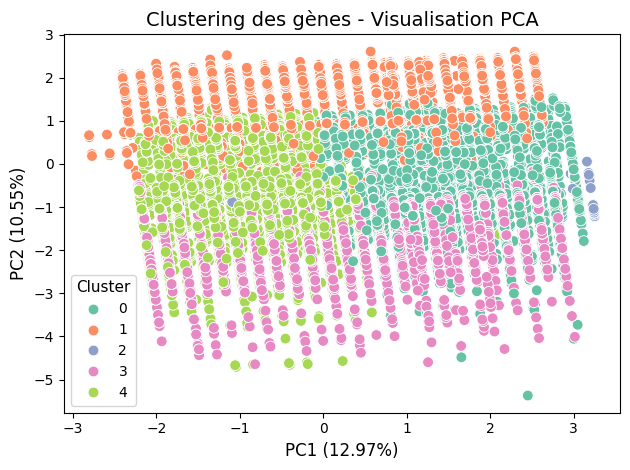

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Préparer les données pour PCA (exclure les colonnes non-numériques)
features_for_pca = clustering_df.drop(columns=[
    'GeneID', 'Symbol', 'type_of_gene', 'description'
], errors='ignore')

# 2. Standardiser les données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_for_pca)

# 3. Appliquer PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# 4. Créer un DataFrame avec les résultats PCA
pca_df = pd.DataFrame({
    'GeneID': clustering_df['GeneID'],
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1],
    # Ajouter les clusters si tu les as déjà calculés
    # 'cluster': cluster_labels
})

# 5. Si tu n'as pas encore de clusters, tu peux faire un clustering (ex: K-means)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)  # 5 clusters comme exemple
cluster_labels = kmeans.fit_predict(scaled_data)
pca_df['cluster'] = cluster_labels

# 6. Visualiser
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster", palette="Set2", ax=ax, s=60)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})", fontsize=12)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})", fontsize=12)
ax.set_title("Clustering des gènes - Visualisation PCA", fontsize=14)
ax.legend(title="Cluster", title_fontsize=11)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

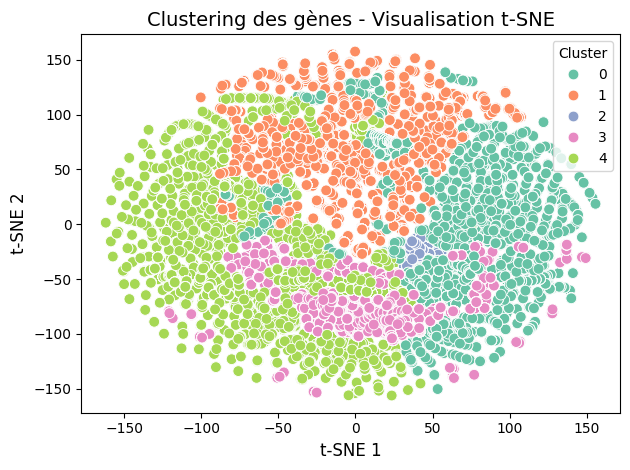

In [ ]:
from sklearn.manifold import TSNE

# 1. Préparer les données
features_for_tsne = clustering_df.drop(columns=[
    'GeneID', 'Symbol', 'type_of_gene', 'description'
], errors='ignore')

# 2. Standardiser
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_for_tsne)

# 3. Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_components = tsne.fit_transform(scaled_data)

# 4. Créer DataFrame
tsne_df = pd.DataFrame({
    'GeneID': clustering_df['GeneID'],
    'tsne-1': tsne_components[:, 0],
    'tsne-2': tsne_components[:, 1],
    'cluster': cluster_labels  # ou les tiens
})

# 5. Visualiser EXACTEMENT comme tu veux
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.scatterplot(data=tsne_df, x="tsne-1", y="tsne-2", hue="cluster", palette="Set2", ax=ax, s=60)

ax.set_xlabel("t-SNE 1", fontsize=12)
ax.set_ylabel("t-SNE 2", fontsize=12)
ax.set_title("Clustering des gènes - Visualisation t-SNE", fontsize=14)
ax.legend(title="Cluster")

plt.tight_layout()
plt.show()